## Urea reconstruction

This notebook creates a plot of reconstructing a urea molecule from moments expanded to various orders showing how this affects the fidelity

In [1]:
import math

import ase.io
from ase import visualize
import numpy as np
from plotly import subplots
import plotly.graph_objects as go
from tqdm import tqdm

import milad
from milad import atomic
from milad.play import asetools
from milad import zernike

import utils

In [2]:
urea = ase.io.read('data/urea.pdb')
max_radius = asetools.prepare_molecule(urea)
cutoff = 1.4 * max_radius

In [3]:
visualize.view(urea, viewer='nglview')

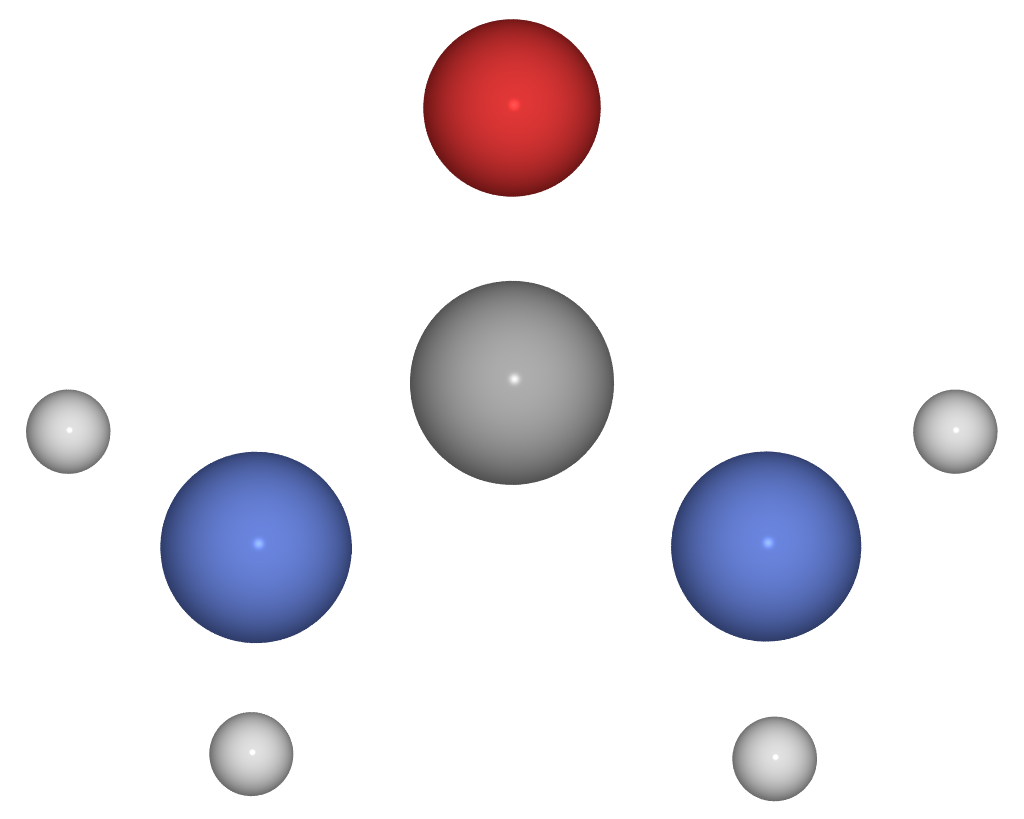

In [4]:
utils.create_povray_img(urea, 'img/urea_top_down', transparent=True, canvas_width=1024, radii=0.6)

Create all the sets of moments in increasing order

In [5]:
milad_molecule = asetools.ase2milad(urea)
# weights = np.array(urea.numbers)
weights = 0.5
max_order = 15
species = tuple(set(urea.numbers))
species_range = (0.5, 5.5)
species_settings = {'map': dict(numbers=species, range=species_range)}

# Create the descriptor
descriptor = milad.descriptor(species = species_settings, cutoff=cutoff)

# Map the species onto a suitable range
mapper = atomic.MapNumbers(tuple(set(milad_molecule.numbers)), species_range)
mapped = mapper(milad_molecule)

# Finally, calculate the moments
moments = zernike.from_deltas(max_order, descriptor.scaler(mapped).positions, weights=mapped.numbers)

Create the grids of values from each set of moments.  `num_samples` defines the grid size in each x, y, and z directions.

In [6]:
num_samples = 51

print(f"Creating {num_samples} * {num_samples} * {num_samples} grid...")
grid = moments.get_grid(num_samples)
print("Creating reconstruction query...")
query = moments.create_reconstruction_query(grid, max_order)
grid_data = []
for order in tqdm(range(0, max_order + 1), "Calculating grid values"):
    grid_data.append(moments.reconstruct(query, order=order))

Creating 51 * 51 * 51 grid...
Creating reconstruction query...


Calculating grid values: 100%|██████████| 16/16 [03:42<00:00, 13.92s/it]


Make a pretty plot of the moments at various orders

In [7]:
cols = 4
rows = int(math.ceil((max_order + 1) / cols))
spacing = 0.04
# Set the colour scale such that white starts first (after all the negative values)
# and then the colours are evenly spaced
colorscale=[(0, '#aabbaa'), (0.35, 'white'), (0.567, 'grey'), (0.78, 'blue'), (1., 'red')]
# colorscale=['#aabbaa', 'white', 'grey', 'blue', 'red']

# Create the titles for each subplot
titles = tuple(f"n = {idx}" for idx in range(max_order + 2))
# Now create the figure with all the subplots in place
fig = subplots.make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=titles,
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=spacing,
    vertical_spacing=spacing,
)

# Get the indices corresponding to the slice we want to plot
slice_indices = np.argwhere(grid[:,2] == 0)
slice_points = grid[slice_indices][:,0,:]
idx = 0
shown_scale = False
for row in range(1, rows + 1):
    for col in range(1, cols + 1):           
        vals = grid_data[idx][slice_indices][:, 0]
        ret = fig.add_trace(go.Contour(
            x=slice_points[:,0],
            y=slice_points[:,1],
            z=vals / vals.max(),
            colorscale=colorscale,
            zmin=-0.2,
            zmax=1.0,
            showscale=not shown_scale,
            connectgaps=False,
        ), row=row, col=col)
        axis = idx + 1
        fig.update_layout({
            f'yaxis{axis}': {'scaleratio':1, 'scaleanchor': f'x{axis}', 'matches': None,},
            f'xaxis{axis}': {'matches': None}
        })
        shown_scale = True

        idx += 1

scale = 250
fig.update_layout(plot_bgcolor='rgba(0.9,0.9,0.9,0.4)', height=scale * rows, width=scale * cols)
fig.update_yaxes(range=(-1, 1))
fig.update_xaxes(range=(-1, 1))

size = 1.7
fig.add_layout_image(
        row=rows, col=cols,
        source="img/urea_top_down.png",
        xref="x",
        yref="y",
        x=0,
        y=-0.01,
        xanchor="center",
        yanchor="middle",
        sizex=size,
        sizey=size,
        opacity=0.75,
)

fig.update_yaxes(matches=None, range=(-1, 1), constrain="domain")
fig.update_xaxes(matches=None, range=(-1, 1), constrain="domain")
fig.show()

Finally save the image

In [8]:
#fig.write_image('img/urea_reconstruction.pdf')